<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/INF0618_Trabalho_01_Kurosawa_Suda_Wakabayashi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inf0618 Deep Learning - Trabalho 1 - CNN**
## Integrantes do grupo:
#### - Daniel Noriaki Kurosawa
#### - Eric Uyemura Suda
#### - Fernando Shigeru Wakabayashi

In [1]:
#Importando as libs necessarias

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras import layers

import seaborn as sns
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4,suppress=True)

In [2]:
# Funcoes auxiliares

def fit_train_eval(model, x_train, y_train_oh, y_val, epochs, batch_size, class_weight, validation_data):
  print("Treinando o Modelo \n\n")
  history = model.fit(x_train, 
                      y_train_oh, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      class_weight=class_weight,
                      validation_data=validation_data)
  
  # Faz as predições para o conjunto de teste
  print("\nFazendo Predicoes da Validacao\n")
  predictions = model_baseline.predict(x_val)
  #score = model.evaluate(x_test, y_test_oh, verbose=1) # Poderia ser usado se o objetivo é ter apenas a métrica.

  #Matriz de confusão
  cm = confusion_matrix(np.argmax(predictions, axis=1), y_val)
  plt.figure(figsize = (11,9))
  ax1=plt.axes()
  ax1.set_title("Matriz de Confusao")
  sns.set(font_scale=0.9)
  sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')

  # Matriz de confusão normalizada
  cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cmn) / num_classes
  print("\n\nAcurácia balanceada:", balanced_acc, "\n")

  plt.figure(figsize = (11,9))
  ax = plt.axes()
  ax.set_title("Matriz de Confusao Balanceada")
  sns.set(font_scale=0.9)
  sns.heatmap(cmn, annot=True, fmt='.1%', cmap='viridis')

  # Curva de Vies Varianca
  return history

In [3]:
#Importando Dataset do trabalho

from tensorflow.keras.datasets import cifar10
(x_trainval, y_trainval), (x_test, y_test) = cifar10.load_data()

In [4]:
#Cada imagem tem o tamanho de 32x32x3

print("Tamanho treino {}".format(x_trainval.shape), "\t", "Tamanho teste {}".format(x_test.shape))

Tamanho treino (50000, 32, 32, 3) 	 Tamanho teste (10000, 32, 32, 3)


In [5]:
#Dataset ja esta balanceado com 5k amostras para cada classe de imagem

unique, counts = np.unique(y_trainval, return_counts=True)
print("Treino ---> ", dict(zip(unique, counts)), "\n")

Treino --->  {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000} 



## 1) Separando Dataset em Treino e Validacao

In [6]:
#Separando o dataset em treino(80%) e validacao(20%)

#Embaralha os dados e divide em 80% para treino, 20% para validação
nData = x_trainval.shape[0]  
nTrain = int(nData * 0.8)  
randomIdx = np.random.permutation(np.arange(nData))
trainIdx = randomIdx[:nTrain] 
valIdx = randomIdx[nTrain:]

#Divide os dados
x_val, y_val = x_trainval[valIdx], y_trainval[valIdx]
x_train, y_train = x_trainval[trainIdx], y_trainval[trainIdx]

print("Formato das imagens de treinamento", x_train.shape)
print("Formato dos rótulos de treinamento", y_train.shape)
print()

print("Formato das imagens de validação", x_val.shape)
print("Formato dos rótulos de validação", y_val.shape)

Formato das imagens de treinamento (40000, 32, 32, 3)
Formato dos rótulos de treinamento (40000, 1)

Formato das imagens de validação (10000, 32, 32, 3)
Formato dos rótulos de validação (10000, 1)


In [7]:
# Escalando dados de para um intervalo de 0-1

x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

In [8]:
# One hot encoding das classes de saida

num_classes = len(np.unique(y_train))
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train_oh.shape)
print("Exemplo: ")
print("Classe Imagem: ", y_train[0], "\tOne Hot: ", y_train_oh[0])

(40000, 32, 32, 3) (40000, 10)
Exemplo: 
Classe Imagem:  [8] 	One Hot:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


## 2) Criando Rede Neural Baseline

In [9]:
# Rede Neural Vanilla

model_baseline = tf.keras.Sequential()
#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_baseline.add(layers.Conv2D(10, 3, padding='valid', activation='relu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline.add(layers.MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline.add(layers.Flatten())
#Densa com 10 nós de saída
model_baseline.add(layers.Dense(10))

model_baseline.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2250)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                22510     
Total params: 22,790
Trainable params: 22,790
Non-trainable params: 0
_________________________________________________________________


Treinando o Modelo 


Epoch 1/32
800/800 [==============================] - 17s 21ms/step - loss: 1.8630 - accuracy: 0.3408 - val_loss: 1.7523 - val_accuracy: 0.3767
Epoch 2/32
800/800 [==============================] - 16s 20ms/step - loss: 1.7365 - accuracy: 0.3826 - val_loss: 1.7420 - val_accuracy: 0.3741
Epoch 3/32
800/800 [==============================] - 16s 20ms/step - loss: 1.7220 - accuracy: 0.3895 - val_loss: 1.7798 - val_accuracy: 0.3652
Epoch 4/32
800/800 [==============================] - 16s 20ms/step - loss: 1.6835 - accuracy: 0.4012 - val_loss: 1.7218 - val_accuracy: 0.3944
Epoch 5/32
800/800 [==============================] - 16s 20ms/step - loss: 1.6532 - accuracy: 0.4097 - val_loss: 1.6611 - val_accuracy: 0.4002
Epoch 6/32
800/800 [==============================] - 16s 20ms/step - loss: 1.6307 - accuracy: 0.4196 - val_loss: 1.6694 - val_accuracy: 0.3990
Epoch 7/32
800/800 [==============================] - 16s 20ms/step - loss: 1.6258 - accuracy: 0.4241 - val_loss: 

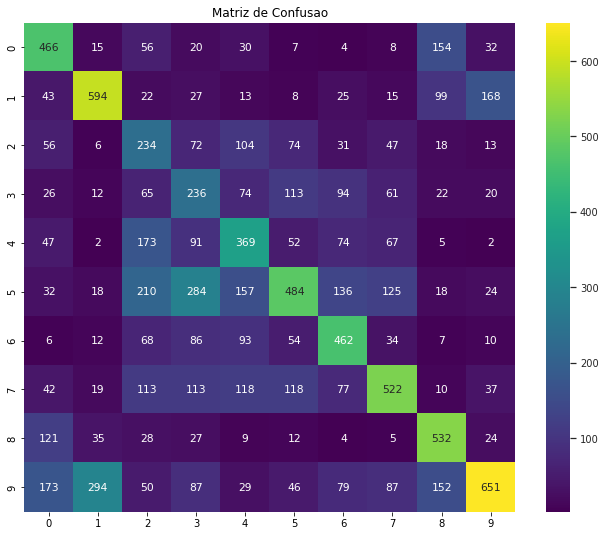

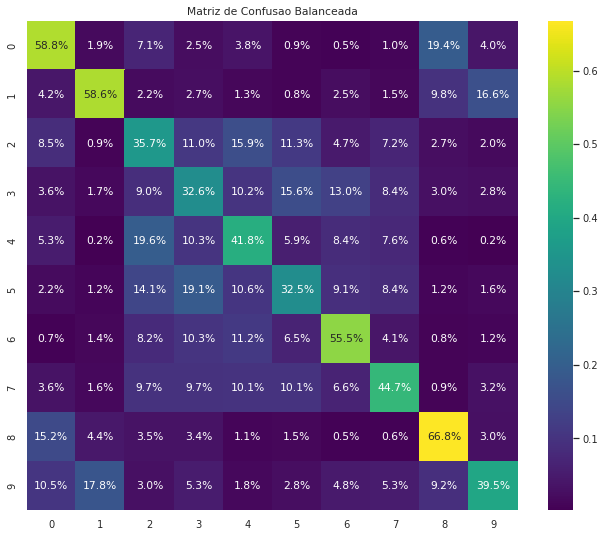

In [10]:
fit_train_eval(model_baseline, x_train, y_train_oh, y_val, epochs=32, batch_size=50, class_weight=None, validation_data=(x_val, y_val_oh))

## 3) Testando Diferentes Funcoes de Ativacao Para o Mesmo Modelo Baseline

[Referencia de Funcoes de Ativacao](https://keras.io/api/layers/activations/)



In [11]:
# Modelo Vanilla com Funcao de Ativacao Sigmoide

model_baseline_sig = tf.keras.Sequential()
#Camada convolucional com 10 filtros de tamanho 3x3 e ativação Sigmoide
model_baseline_sig.add(layers.Conv2D(10, 3, padding='valid', activation='sigmoid', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline_sig.add(layers.MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_sig.add(layers.Flatten())
#Densa com 10 nós de saída
model_baseline_sig.add(layers.Dense(10))

model_baseline_sig.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_baseline_sig.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2250)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                22510     
Total params: 22,790
Trainable params: 22,790
Non-trainable params: 0
_________________________________________________________________


Treinando o Modelo 


Epoch 1/50
1250/1250 [==============================] - 20s 15ms/step - loss: 2.0231 - accuracy: 0.3165 - val_loss: 1.7836 - val_accuracy: 0.3930
Epoch 2/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.7036 - accuracy: 0.4050 - val_loss: 1.6567 - val_accuracy: 0.4238
Epoch 3/50
1250/1250 [==============================] - 19s 16ms/step - loss: 1.6103 - accuracy: 0.4376 - val_loss: 1.5962 - val_accuracy: 0.4405
Epoch 4/50
1250/1250 [==============================] - 19s 16ms/step - loss: 1.5423 - accuracy: 0.4633 - val_loss: 1.5866 - val_accuracy: 0.4393
Epoch 5/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4924 - accuracy: 0.4773 - val_loss: 1.4896 - val_accuracy: 0.4784
Epoch 6/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4338 - accuracy: 0.5008 - val_loss: 1.4791 - val_accuracy: 0.4926
Epoch 7/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.3795 - accuracy: 0.520

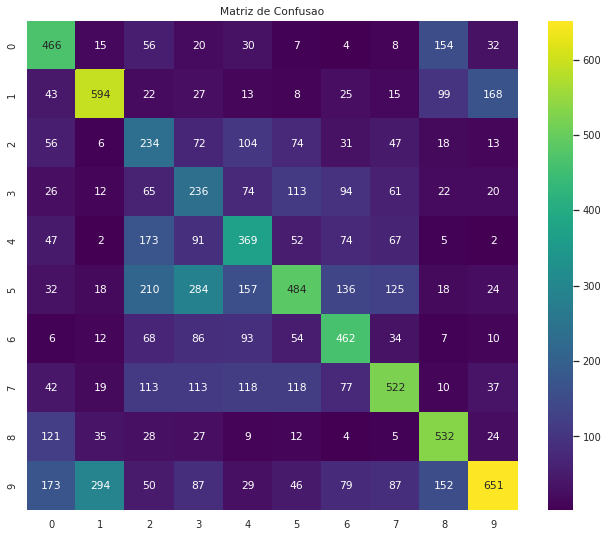

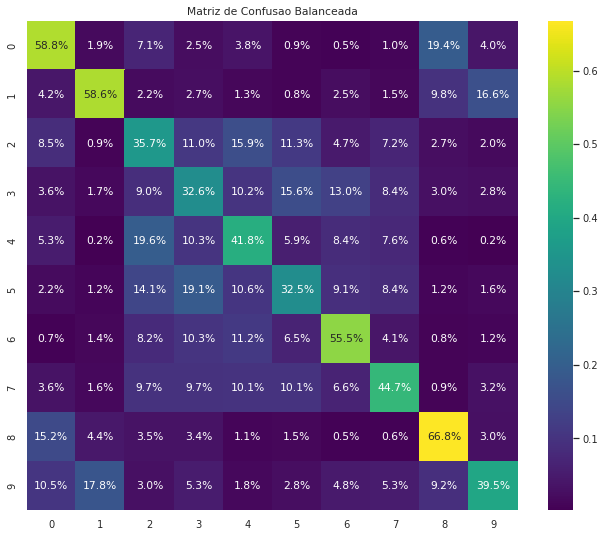

In [12]:
fit_train_eval(model_baseline_sig, x_train, y_train_oh, y_val, epochs=50, batch_size=32, class_weight=None, validation_data=(x_val, y_val_oh))

In [13]:
# Modelo Vanilla com Funcao de Ativacao Tangente Hiperbolica

model_baseline_hip = tf.keras.Sequential()
#Camada convolucional com 10 filtros de tamanho 3x3 e ativação Sigmoide
model_baseline_hip.add(layers.Conv2D(10, 3, padding='valid', activation='tanh', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline_hip.add(layers.MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_hip.add(layers.Flatten())
#Densa com 10 nós de saída
model_baseline_hip.add(layers.Dense(10))

model_baseline_hip.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_baseline_hip.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2250)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                22510     
Total params: 22,790
Trainable params: 22,790
Non-trainable params: 0
_________________________________________________________________


Treinando o Modelo 


Epoch 1/50
1250/1250 [==============================] - 21s 16ms/step - loss: 1.7774 - accuracy: 0.3964 - val_loss: 1.7713 - val_accuracy: 0.4188
Epoch 2/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.5910 - accuracy: 0.4706 - val_loss: 2.0506 - val_accuracy: 0.3985
Epoch 3/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.5069 - accuracy: 0.5021 - val_loss: 1.5120 - val_accuracy: 0.4978
Epoch 4/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4982 - accuracy: 0.5078 - val_loss: 1.5750 - val_accuracy: 0.4823
Epoch 5/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4653 - accuracy: 0.5180 - val_loss: 1.6502 - val_accuracy: 0.4831
Epoch 6/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4335 - accuracy: 0.5310 - val_loss: 1.5342 - val_accuracy: 0.5036
Epoch 7/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4240 - accuracy: 0.535

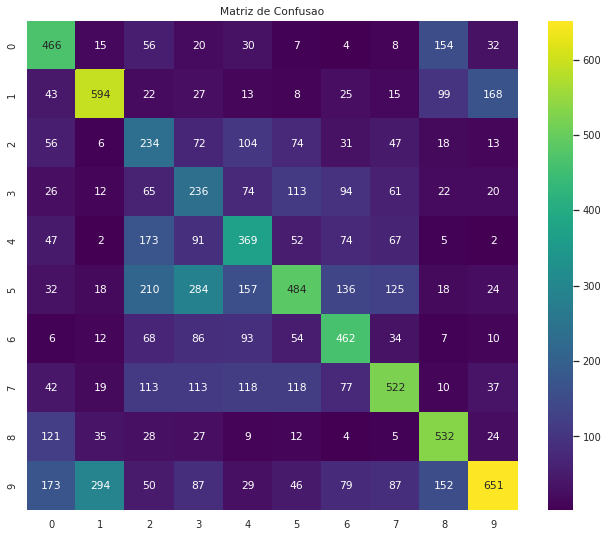

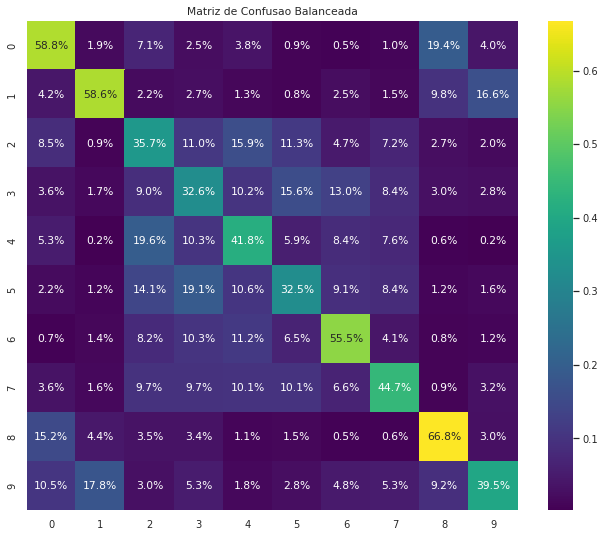

In [14]:
fit_train_eval(model_baseline_hip, x_train, y_train_oh, y_val, epochs=50, batch_size=32, class_weight=None, validation_data=(x_val, y_val_oh))

In [15]:
# Modelo Vanilla com Funcao de Ativacao SeLu

model_baseline_selu = tf.keras.Sequential()
#Camada convolucional com 10 filtros de tamanho 3x3 e ativação Sigmoide
model_baseline_selu.add(layers.Conv2D(10, 3, padding='valid', activation='selu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline_selu.add(layers.MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_selu.add(layers.Flatten())
#Densa com 10 nós de saída
model_baseline_selu.add(layers.Dense(10))

model_baseline_selu.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_baseline_selu.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2250)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                22510     
Total params: 22,790
Trainable params: 22,790
Non-trainable params: 0
_________________________________________________________________


Treinando o Modelo 


Epoch 1/32
800/800 [==============================] - 19s 23ms/step - loss: 1.7618 - accuracy: 0.3977 - val_loss: 1.6112 - val_accuracy: 0.4426
Epoch 2/32
800/800 [==============================] - 18s 23ms/step - loss: 1.5831 - accuracy: 0.4635 - val_loss: 1.5262 - val_accuracy: 0.4879
Epoch 3/32
800/800 [==============================] - 18s 23ms/step - loss: 1.4938 - accuracy: 0.5007 - val_loss: 1.5796 - val_accuracy: 0.4905
Epoch 4/32
800/800 [==============================] - 18s 23ms/step - loss: 1.4370 - accuracy: 0.5197 - val_loss: 1.5223 - val_accuracy: 0.4959
Epoch 5/32
800/800 [==============================] - 19s 23ms/step - loss: 1.4183 - accuracy: 0.5290 - val_loss: 1.6950 - val_accuracy: 0.4542
Epoch 6/32
800/800 [==============================] - 18s 23ms/step - loss: 1.4342 - accuracy: 0.5264 - val_loss: 1.7856 - val_accuracy: 0.4519
Epoch 7/32
800/800 [==============================] - 19s 23ms/step - loss: 1.3997 - accuracy: 0.5358 - val_loss: 

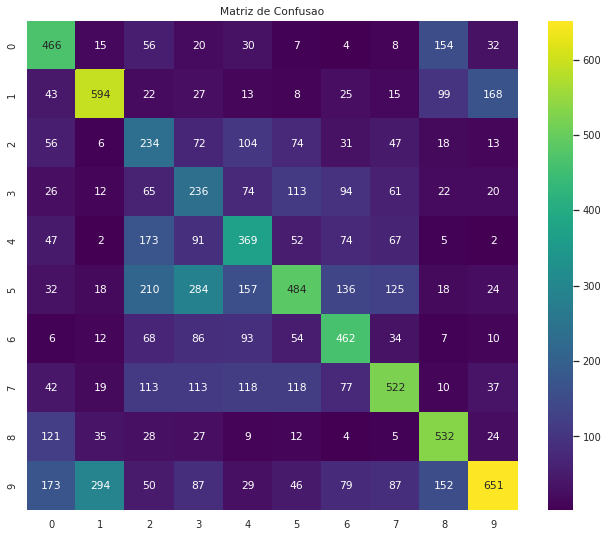

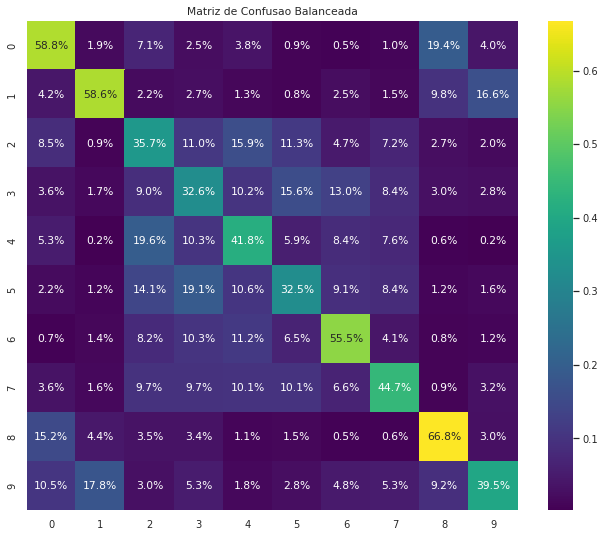

In [16]:
fit_train_eval(model_baseline_selu, x_train, y_train_oh, y_val, epochs=32, batch_size=50, class_weight=None, validation_data=(x_val, y_val_oh))